In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns

In [16]:
BATCH_SIZE = 5
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [17]:
# Import data into tensorflow dataset object

In [18]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Lumpy",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 112 files belonging to 2 classes.


In [19]:
class_names=dataset.class_names
class_names

['Healthy', 'lumpy Disease']

In [20]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(5, 256, 256, 3)
[1 0 0 1 0]


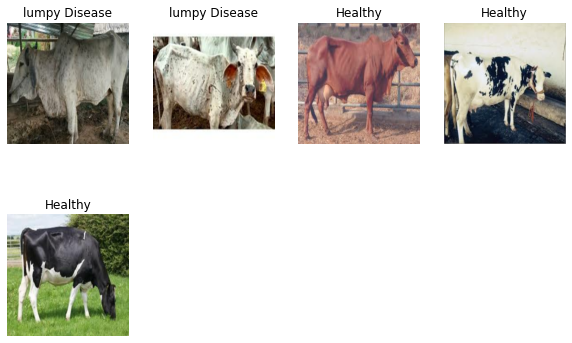

In [21]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(5):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [22]:
len(dataset)

23

In [23]:
train=0.8
train*len(dataset)

18.400000000000002

In [24]:
df_test=dataset.skip(18)
val_df=df_test

In [25]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [26]:
train_df,val_df,test_df=get_dataset_partitions_tf(dataset)

In [27]:
train_ds = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [29]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.25),
    layers.experimental.preprocessing.RandomZoom((0.5,0.2)),
    layers.experimental.preprocessing.RandomZoom((-0.7,-0.2)),
    layers.experimental.preprocessing.RandomContrast(factor=0.1)
])

In [30]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    #data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),   # Flatten the array
    layers.Dense(64, activation='relu'),  # Hidden Layer
    layers.Dense(n_classes, activation='sigmoid'), #output layer
])

model.build(input_shape=input_shape)

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (5, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (5, 254, 254, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2D  (5, 127, 127, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (5, 125, 125, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (5, 62, 62, 64)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (5, 60, 60, 64)          

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
18/18 [==============================] - 8s 282ms/step - loss: 0.7026 - accuracy: 0.3563 - val_loss: 0.6934 - val_accuracy: 0.4000
Epoch 2/50
18/18 [==============================] - 8s 433ms/step - loss: 0.6927 - accuracy: 0.4943 - val_loss: 0.6850 - val_accuracy: 0.8000
Epoch 3/50
18/18 [==============================] - 9s 482ms/step - loss: 0.6951 - accuracy: 0.5747 - val_loss: 0.6966 - val_accuracy: 0.3000
Epoch 4/50
18/18 [==============================] - 10s 525ms/step - loss: 0.6885 - accuracy: 0.5862 - val_loss: 0.5333 - val_accuracy: 0.8000
Epoch 5/50
18/18 [==============================] - 8s 452ms/step - loss: 0.6623 - accuracy: 0.6552 - val_loss: 0.5594 - val_accuracy: 0.7000
Epoch 6/50
18/18 [==============================] - 9s 458ms/step - loss: 0.6140 - accuracy: 0.5977 - val_loss: 0.5117 - val_accuracy: 0.7000
Epoch 7/50
18/18 [==============================] - 9s 488ms/step - loss: 0.6654 - accuracy: 0.5517 - val_loss: 0.4470 - val_accuracy: 0.7000
Epoch

In [35]:
model.evaluate(test_ds)

3/3 [==============================] - 0s 85ms/step - loss: 0.4707 - accuracy: 0.8333


[0.4707482159137726, 0.8333333134651184]

In [47]:
def Predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    print(predictions)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class,confidence

In [60]:
from tensorflow import keras
model1 = keras.models.load_model('CNN.h5')
for img,label in test_df.take(1):
    for i in range(5):
        img_array=tf.keras.preprocessing.image.img_to_array(img[i].numpy())
        img_array=tf.expand_dims(img_array,0)
        predictions = model1.predict(img_array)
        print(class_names[np.argmax(predictions[0])],np.max(predictions[0]))

1/1 [==============================] - 0s 112ms/step
lumpy Disease 0.49242973
1/1 [==============================] - 0s 35ms/step
Healthy 0.57136214
1/1 [==============================] - 0s 36ms/step
Healthy 0.78059465
1/1 [==============================] - 0s 37ms/step
Healthy 0.5587865
1/1 [==============================] - 0s 45ms/step
lumpy Disease 0.69150096


1/1 [==============================] - 0s 30ms/step
[[0.95061564 0.06738706]]
1/1 [==============================] - 0s 37ms/step
[[0.16246256 0.8118557 ]]
1/1 [==============================] - 0s 28ms/step
[[0.91227835 0.1043849 ]]
1/1 [==============================] - 0s 35ms/step
[[0.32291138 0.6772803 ]]
1/1 [==============================] - 0s 34ms/step
[[0.8905299  0.12374716]]


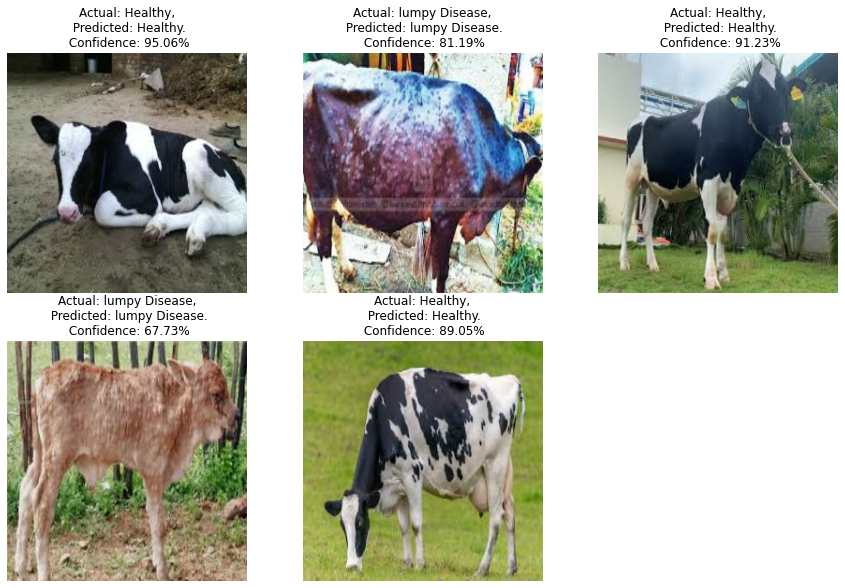

In [49]:
import numpy as np

plt.figure(figsize=(15, 15))
for img,label in test_df.take(1):
    for i in range(5):
        plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        pred,conf=Predict(model,img[i].numpy())
#         print(pred,conf)
        actual_class = class_names[label[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {pred}.\n Confidence: {conf}%")
        plt.axis("off")

1/1 [==============================] - 0s 32ms/step


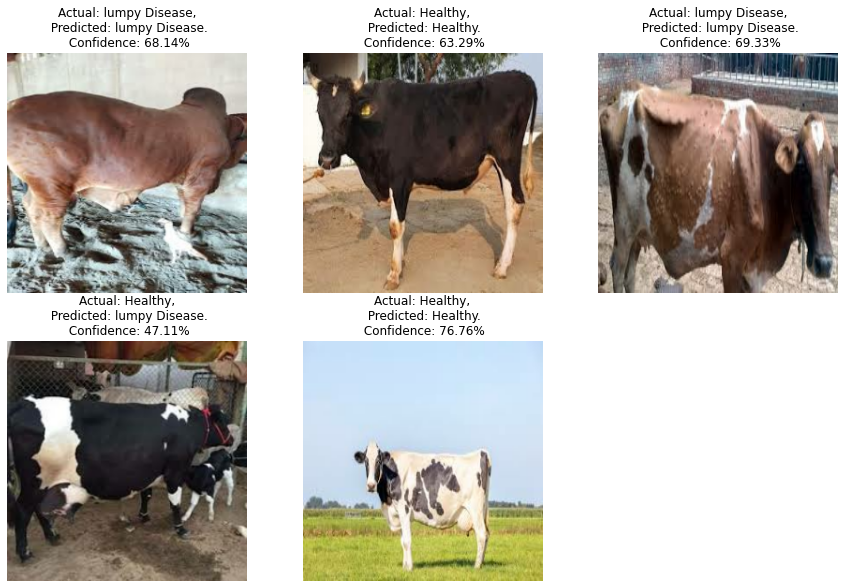

In [46]:
import numpy as np
plt.figure(figsize=(15, 15))
for img,label in test_df.take(2):
    for i in range(5):
        plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        pred,conf=Predict(model,img[i].numpy())
        actual_class = class_names[label[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {pred}.\n Confidence: {conf}%")
        plt.axis("off")

1/1 [==============================] - 0s 56ms/step


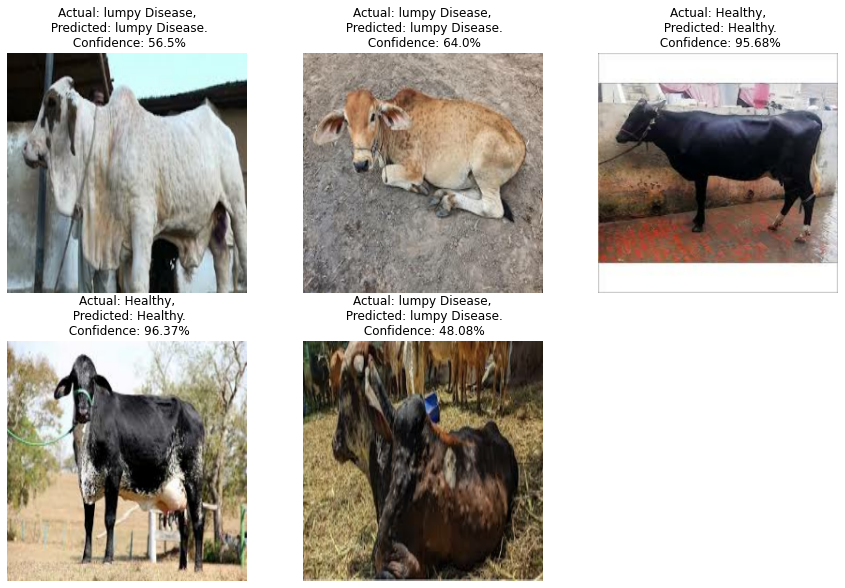

In [40]:
import numpy as np
plt.figure(figsize=(15, 15))
for img,label in test_df.take(3):
    for i in range(5):
        plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        pred,conf=Predict(model,img[i].numpy())
        actual_class = class_names[label[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {pred}.\n Confidence: {conf}%")
        plt.axis("off")

1/1 [==============================] - 0s 64ms/step


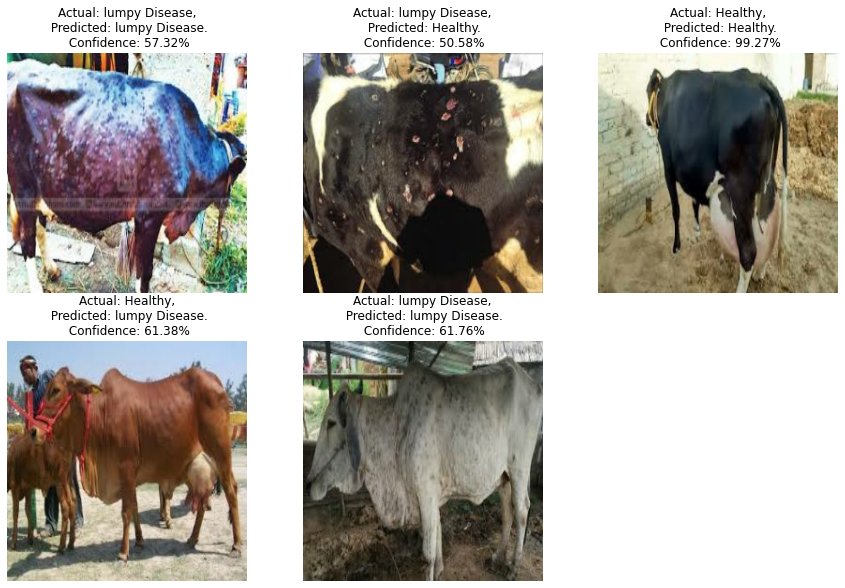

In [41]:
import numpy as np
plt.figure(figsize=(15, 15))
for img,label in test_df.take(4):
    for i in range(5):
        plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        pred,conf=Predict(model,img[i].numpy())
        actual_class = class_names[label[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {pred}.\n Confidence: {conf}%")
        plt.axis("off")

1/1 [==============================] - 0s 33ms/step


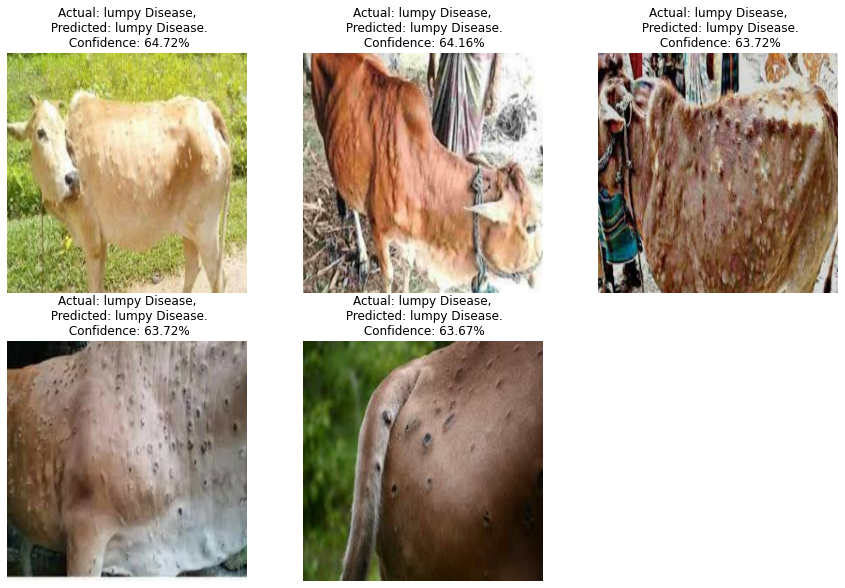

In [42]:
import numpy as np
plt.figure(figsize=(15, 15))
for img,label in test_df.take(5):
    for i in range(5):
        plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        pred,conf=Predict(model,img[i].numpy())
        actual_class = class_names[label[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {pred}.\n Confidence: {conf}%")
        plt.axis("off")